# Proyecto 7

Área: Medio Ambiente

Descripción: Deberán **modelar** el consumo de agua en una ciudad durante varios meses o años, utilizando diferentes variables. El objetivo es **identificar** patrones de uso, **predecir** la demanda futura y **evaluar** posibles escenarios de escasez mediante **simulaciones**.


---

### Librerias importadas

In [235]:
import numpy as np 
import pandas as pd 
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style('whitegrid')

### Funciones utilizadas

Funciones utilizadas en la preparación de datos.

In [ ]:
def normalizar(serie, archivo_csv):
    df_temp= pd.read_csv(archivo_csv)
    scaler = MinMaxScaler()
    df_normalizado = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns)
    return df_normalizado

Funciones para calcular estadisticas, diferenciar una serie de tiempo y graficar los resultados:

<Aquí deberia ir separado cada función con una breve explicación de lo que hace>

In [164]:
def diferenciar(serie):
    df_diferenciado = serie.copy()
    df_diferenciado["Consumo"] = serie["Consumo"].diff(periods=12)
    df_diferenciado = df_diferenciado.dropna().reset_index(drop=True)
    return df_diferenciado

def graficar(serie):
    df_temp = serie.copy().set_index('Fecha')
    df_temp.plot()

def calcular_estadisticas(serie):
    df_estadisticas = serie.copy()
    df_estadisticas['Año'] = df_estadisticas['Fecha'].dt.year
    estadisticas = df_estadisticas.groupby('Año')['Consumo'].agg([
    'mean',       # media
    'std',        # desviación estándar
    ])
    display(estadisticas)
    estadisticas[['mean', 'std']].plot(title='Media y desviación estándar por año')
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show()

def periodograma(serie):
    temp = serie["Consumo"]
    valores = temp.values
    n = len(valores)

    frecuencias = np.fft.fftfreq(n, d=1)  
    espectro = np.fft.fft(valores)
    potencia = np.abs(espectro) ** 2

    positivas = frecuencias > 0

    plt.plot(frecuencias[positivas], potencia[positivas])
    plt.title("Espectro de Potencia (FFT)")
    plt.xlabel("Frecuencia (ciclos por unidad de tiempo)")
    plt.ylabel("Potencia")
    plt.grid(True)
    plt.show()



Funciones para calcular reazagos utilizados para la ACF (función de autocorrelación):

<Aquí deberia ir separado cada función con una breve explicación de lo que hace>

In [163]:
def calcular_n_rezagos(serie):
    return int(len(serie) / 4)

def numerador_rk(serie, promedio,k):
    T = len(serie)
    suma = 0
    
    for t in range(k+1, T):
        suma += (serie[t] - promedio) * (serie[t - k] - promedio)
    return suma


def denominador_rk(serie, promedio):
    T = len(serie)
    suma = 0

    for t in range(1, T):
        suma += (serie[t] - promedio)**2
    return suma

def coeficientes_rk(serie):
    n_rezagos = calcular_n_rezagos(serie)
    promedio = serie["Consumo"].sum() / len(serie)
    
    denominador = denominador_rk(serie["Consumo"].values, promedio)

    r = np.empty(n_rezagos, dtype=float)
    for k in range (0 , n_rezagos):
        numerador = numerador_rk(serie["Consumo"].values, promedio, k)
        r[k] = numerador/denominador

    graficar_coeficientes_rk(serie, r)
    return r

def graficar_coeficientes_rk(serie, rk):
    n = len(serie)
    k_vals = np.arange(len(rk)) 

    plt.figure(figsize=(10, 5))
    plt.stem(k_vals, rk, basefmt=" ")
    plt.axhline(0, color='black', linewidth=1)
    plt.title("Correlograma Muestral (ACF)")
    plt.xlabel("Rezago (k)")
    plt.ylabel("rk")
    plt.xticks(k_vals)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Funciones para la parte de PACF

<>

In [181]:
def calcular_yt(serie):
    promedio = serie['Consumo'].mean()
    n_datos = len(serie)

    y = np.empty(n_datos, dtype=float)

    for t in range(0, n_datos):
        y[t] = serie['Consumo'].iloc[t] - promedio
    
    return y      

def calcular_pacf(y, max_lag):
    y = np.asarray(y)
    n = len(y)
    pacf = [1.0]  # PACF en lag 0 siempre es 1

    for k in range(1, max_lag + 1):
        # Crear matriz X con las columnas Y_{t-1}, ..., Y_{t-k}
        X = np.column_stack([y[i: n - k + i] for i in range(k)])
        y_target = y[k:]
        
        modelo = LinearRegression().fit(X, y_target)
        
        # Coeficiente del lag más lejano (el k-ésimo rezago)
        pacf_k = modelo.coef_[-1]
        pacf.append(pacf_k)

    return pacf

---

## Análisis del dataset

Analizamos las columnas del data set, de esto posteriormente nos interezará conocer cuantos valores NaN (Not a Number) tenemos y en que columnas.

In [238]:
aguah = pd.read_csv("AguaH.csv")
aguah

USO2013                     TU   DC                M      UL  \
0           H3        DOMESTICO MEDIO  0.5       MSDELAUNET   197.0   
1           H3        DOMESTICO MEDIO  0.5       MSDELAUNET   307.0   
2           H3  DOMESTICO RESIDENCIAL  0.5       MSDELAUNET   179.0   
3           H3        DOMESTICO MEDIO  0.5  CICASA MMD-15 S   852.0   
4           H3  DOMESTICO RESIDENCIAL  0.5              NaN     NaN   
...        ...                    ...  ...              ...     ...   
178592     RHC              COMERCIAL  3.0            ADCOM  6614.0   
178593      MX              COMERCIAL  3.0            ADCOM  6614.0   
178594     RHC              COMERCIAL  3.0            ADCOM  6614.0   
178595      MX              COMERCIAL  3.0            ADCOM  6614.0   
178596      MX              COMERCIAL  3.0            ADCOM  6614.0   

        f.1_ENE_09  f.1_FEB_09  f.1_MAR_09  f.1_ABR_09  f.1_MAY_09  ...  \
0             20.0        20.0        20.0        20.0        20.0  ...   
1              NaN        30.0        30.0        30.0        30.0  ...   
2              NaN         NaN         NaN         NaN         NaN  ...   
3              NaN         NaN         NaN         NaN         NaN  ...   
4             20.0        20.0        20.0        20.0        20.0  ...   
...            ...         ...         ...         ...         ...  ...   
178592      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178593      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178594      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178595      2574.0      1685.0      1141.0      1316.0      1521.0  ...   
178596      2574.0      1685.0      1141.0      1316.0      1521.0  ...   

        f.1_MAR_15  f.1_ABR_15  f.1_MAY_15  f.1_JUN_15  f.1_JUL_15  \
0              2.0         1.0         2.0         1.0         7.0   
1             11.0        13.0        16.0        14.0        15.0   
2              6.0         9.0         7.0         8.0         8.0   
3             17.0        20.0        16.0        16.0        18.0   
4             27.0        27.0        27.0        28.0        28.0   
...            ...         ...         ...         ...         ...   
178592      4924.0      4346.0      5118.0      4755.0      6444.0   
178593      4924.0      4346.0      5118.0      4755.0      6444.0   
178594      4924.0      4346.0      5118.0      4755.0      6444.0   
178595      4924.0      4346.0      5118.0      4755.0      6444.0   
178596      4924.0      4346.0      5118.0      4755.0      6444.0   

        f.1_AGO_15  f.1_SEP_15  f.1_OCT_15  f.1_NOV_15  f.1_DIC_15  
0              7.0        42.0        27.0        22.0        21.0  
1             16.0        13.0        17.0        17.0        11.0  
2             10.0        12.0         9.0         6.0         3.0  
3             18.0        17.0        17.0        18.0         9.0  
4             31.0        27.0        27.0        27.0        24.0  
...            ...         ...         ...         ...         ...  
178592      5783.0      6476.0      3123.0      4756.0      4435.0  
178593      5783.0      6476.0      3123.0      4756.0      4435.0  
178594      5783.0      6476.0      3123.0      4756.0      4435.0  
178595      5783.0      6476.0      3123.0      4756.0      4435.0  
178596      5783.0      6476.0      3123.0      4756.0      4435.0  

[178597 rows x 89 columns]

In [138]:
lookup = {'ENE':'01',
          'FEB':'02',
          'MAR':'03',
          'ABR':'04',
          'MAY':'05',
          'JUN':'06',
          'JUL':'07',
          'AGO':'08',
          'SEP':'09',
          'OCT':'10',
          'NOV':'11',
          'DIC':'12'
          }
clist=[]
for col in aguah.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]])

columns = ['TIPO USO','TIPO USUARIO','DIAMETRO_TUBERIA','PROVEEDOR','ENE16']+clist
aguah.columns=columns
aguah.head()

TIPO USO           TIPO USUARIO  DIAMETRO_TUBERIA        PROVEEDOR  ENE16  \
0       H3        DOMESTICO MEDIO               0.5       MSDELAUNET  197.0   
1       H3        DOMESTICO MEDIO               0.5       MSDELAUNET  307.0   
2       H3  DOMESTICO RESIDENCIAL               0.5       MSDELAUNET  179.0   
3       H3        DOMESTICO MEDIO               0.5  CICASA MMD-15 S  852.0   
4       H3  DOMESTICO RESIDENCIAL               0.5              NaN    NaN   

   2009-01  2009-02  2009-03  2009-04  2009-05  ...  2015-03  2015-04  \
0     20.0     20.0     20.0     20.0     20.0  ...      2.0      1.0   
1      NaN     30.0     30.0     30.0     30.0  ...     11.0     13.0   
2      NaN      NaN      NaN      NaN      NaN  ...      6.0      9.0   
3      NaN      NaN      NaN      NaN      NaN  ...     17.0     20.0   
4     20.0     20.0     20.0     20.0     20.0  ...     27.0     27.0   

   2015-05  2015-06  2015-07  2015-08  2015-09  2015-10  2015-11  2015-12  
0      2.0      1.0      7.0      7.0     42.0     27.0     22.0     21.0  
1     16.0     14.0     15.0     16.0     13.0     17.0     17.0     11.0  
2      7.0      8.0      8.0     10.0     12.0      9.0      6.0      3.0  
3     16.0     16.0     18.0     18.0     17.0     17.0     18.0      9.0  
4     27.0     28.0     28.0     31.0     27.0     27.0     27.0     24.0  

[5 rows x 89 columns]

### Datos nulos (NaN)

Identificamos los valores diferentes de NaN, mismos que nos serviran para imputar los datos NaN posteriormente:

Proporción de valores distintos de NaN : 79.06%


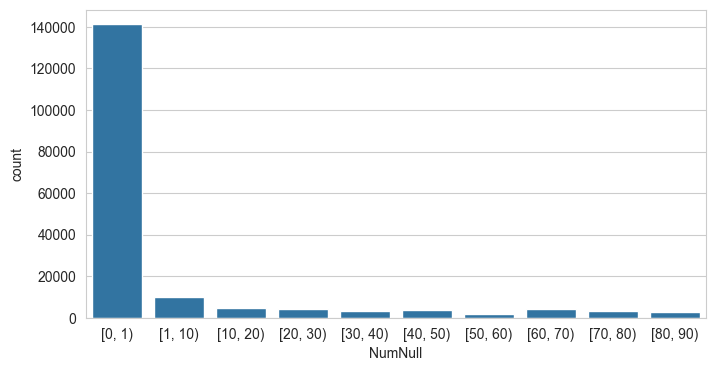

In [139]:
cons = aguah.iloc[0:, 5:]
cons['NumNull'] = cons.isnull().sum(axis=1)
print('Proporción de valores distintos de NaN : {:.2f}%'.format(len(cons[cons.NumNull==0])/len(cons)*100))
bins = [0,1,10,20,30,40,50,60,70,80,90]
cut = pd.cut(cons.NumNull, bins=bins, include_lowest=True, right=False)
fig, axis1 = plt.subplots(1,figsize=(8,4))
sns.countplot(x=cut, data=cut.to_frame(), ax=axis1)
plt.show()

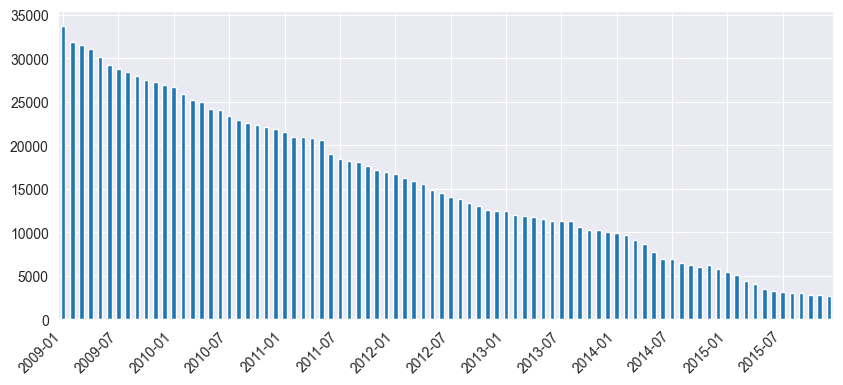

In [140]:
NumNullwithTime = cons.drop('NumNull', axis=1).isnull().sum()

sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
pbar = NumNullwithTime.plot.bar()
plt.xticks(list(range(0,len(NumNullwithTime.index),6)), list(NumNullwithTime.index[0::6]), rotation=45, ha='right')
plt.show()

* **Clasificación de los datos**

Debido al comportamiento de los valores NaN, podemos calsificar a los usuarios (filas) en tres tipos: Completos, Interrumpidos y usuarios con un inicio tardio o un fin prematuro en 
el consumo.
Para la clasificación de los usuarios se tomaron encuenta solo los valores NaN dentro de los días de servicio, es decir se toman en cuenta solo los NaN dentro del intervalo
de datos desde el primer dato diferente de NaN hasta el último diferente de NaN.

El objetivo de la clasificación es descartar datos NaN debidos a un comienzo tardio en el consumo o un final prematuro en el consumo, y de esta forma solo imputar los NaN "injustificados"
es decir los datos registrados como NaN dentro de un periodo en el que se deberia estar consumiendo.

In [242]:
## Return index of column (0-83) where the first non-NA number appears. If none, return 84
def FirstNonNull(row):
    count=0
    for col in row:
        if col==False: return count
        else: count = count+1
    return count

## Return index of column (0-83) where the last non-NA number appears, If none, return -1
def LastNonNull(row):
    count=0
    flag=-1
    for col in row:
        if col==False:
            flag=count
            count=count+1
        else: count=count+1
    return flag
## I need this function for the cases of all NaN entries (NullinService value becomes 0 from -83)
def Setzero(x):
    if x<0: return 0
    else: return x

## Number of NaN values before service period
groupnull = aguah.iloc[:,0:5]
groupnull = pd.concat([groupnull, cons], axis=1)

groupnull['FirstNonNull'] = cons.copy().drop(['NumNull'], axis=1).isnull().apply(FirstNonNull,axis=1)
groupnull['LastNonNull'] = cons.copy().drop(['NumNull'],axis=1).isnull().apply(LastNonNull,axis=1)
groupnull['NullInService'] = groupnull.NumNull - groupnull.FirstNonNull - (len(cons.columns)-1-groupnull.LastNonNull) +1    
groupnull['NullInService'] = groupnull['NullInService'].apply(Setzero)
groupnull.NullInService.value_counts(sort=False).head(6) ## Print only head values

NullInService
0     173773
1       3894
2        489
3        197
4         80
75         1
Name: count, dtype: int64

In [243]:
contLong = groupnull[groupnull.NumNull==0]
contShort = groupnull[(groupnull.NumNull>0) & (groupnull.NullInService==0)]
interupted = groupnull[(groupnull.NullInService)>0]
print('Length of 3 groups: (Non-NA Group, Edge-NA Group, Interupted Group) = ({}, {}, {})'.format(len(contLong), len(contShort), len(interupted)))

Length of 3 groups: (Non-NA Group, Edge-NA Group, Interupted Group) = (141205, 32568, 4824)


---

### Preparación de los datos


* **Usando KNN**

In [253]:
def KnnImputeSimple(sample, x, k):
    ## Mask the columns with NaN value (not to compare)
    x_mask = x.notnull().tolist()
    x_mask_toggled = x.isnull().tolist()
    sample_masked = sample.iloc[:,x_mask]
    x_masked = x[x_mask]
    
    ## Extent to which column comparison is carried out. Here 6 columns (months) before and after the the column in question
    comp_size = 6
    i = x_mask_toggled.index(True)
    ## Handle when there are less than 4 columns to look at before or after the column in question
    i = max(comp_size, min(i, 84-1-comp_size))
    x_masked = x_masked[i-comp_size:i+comp_size].values
    sample_masked = sample_masked.iloc[:,i-comp_size:i+comp_size]
    
    ## I use kd_tree algorithm here.
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
    nbrs.fit(sample_masked)
    n_ones = nbrs.kneighbors([x_masked])
    
    ## Find k nearest ones and average the predicted values to return
    value = []
    for n in range(x.isnull().sum()):
        temp=[]
        for j in range(k):
            temp.append(sample.iloc[n_ones[1][0][j]][x_mask_toggled][n])
        value.append(np.sum(temp)/k)

    return value

def KnnImputeInPlace(sample, itrp, k):
    fn = itrp['FirstNonNull']
    ln = itrp['LastNonNull']
    serv = itrp[int(fn):int(ln)+1]
    

    index = serv[serv.isnull()].index.tolist()
    itrp_imputed = itrp
    for i in range(len(index)):
        idx = index.copy()
        idx.pop(i)
        imp = KnnImputeSimple(sample.iloc[:,int(fn):int(ln)+1].drop(sample[idx],axis=1), serv.drop(idx), k)
        itrp_imputed.iloc[i] = imp[0]
    
    return itrp_imputed

In [254]:
## For KNN, choose the size of sample table (same as missing_rate above)
rng = np.random.RandomState(0)
samp_rate = 0.01  ## Here, 1 for use the whole set of entries to search (0.01 only for display)

## Prepare a reference set within Non-NA Group 
num_total = len(contLong)
num_samp = int(np.floor(samp_rate*num_total))
rand_samp = np.hstack((np.zeros(num_total-num_samp, dtype=np.bool), np.ones(num_samp, dtype=np.bool)))
rng.shuffle(rand_samp)
sample = contLong.iloc[:,5:89][rand_samp.tolist()]

In [255]:
## KNN imputation (warning it may take a couple of minutes)
itrp = interupted.copy()[(interupted.NullInService>0) & (interupted.NullInService<6)].iloc[:,5:]
result_knn = itrp.apply(lambda x: KnnImputeInPlace(sample, x, 2), axis=1)
result_knn_head = interupted.copy()[(interupted.NullInService>0) & (interupted.NullInService<6)].iloc[:,0:5]
result_knn = pd.concat([result_knn_head, result_knn],axis=1)
result_knn.shape

c:\Users\Sachistein\Proyecto_MN\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\3766263739.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp.append(sample.iloc[n_ones[1][0][j]][x_mask_toggled][n])
C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\3766263739.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp.append(sample.iloc[n_ones[1][0][j]][x_mask_toggled][n])
c:\Users\Sachistein\Proyecto_MN\env\Lib\site-packages\sklear

(4705, 93)

In [258]:
## Linear imputation 
itrp = interupted.copy()[(interupted.NullInService>5) & (interupted.NullInService<84)].iloc[:,5:]
itrp.interpolate(method='linear', axis=1, inplace=True)
result_fill_head = interupted.copy()[(interupted.NullInService>5) & (interupted.NullInService<84)].iloc[:,0:5]
result_fill = pd.concat([result_fill_head, itrp],axis=1)
result_fill.shape

(119, 93)

In [259]:
result = pd.concat([contLong, contShort, result_knn, result_fill])
result = result.iloc[:,:89]
result.shape

(178597, 89)

In [261]:
result.to_csv('datos_imputados_KNN')

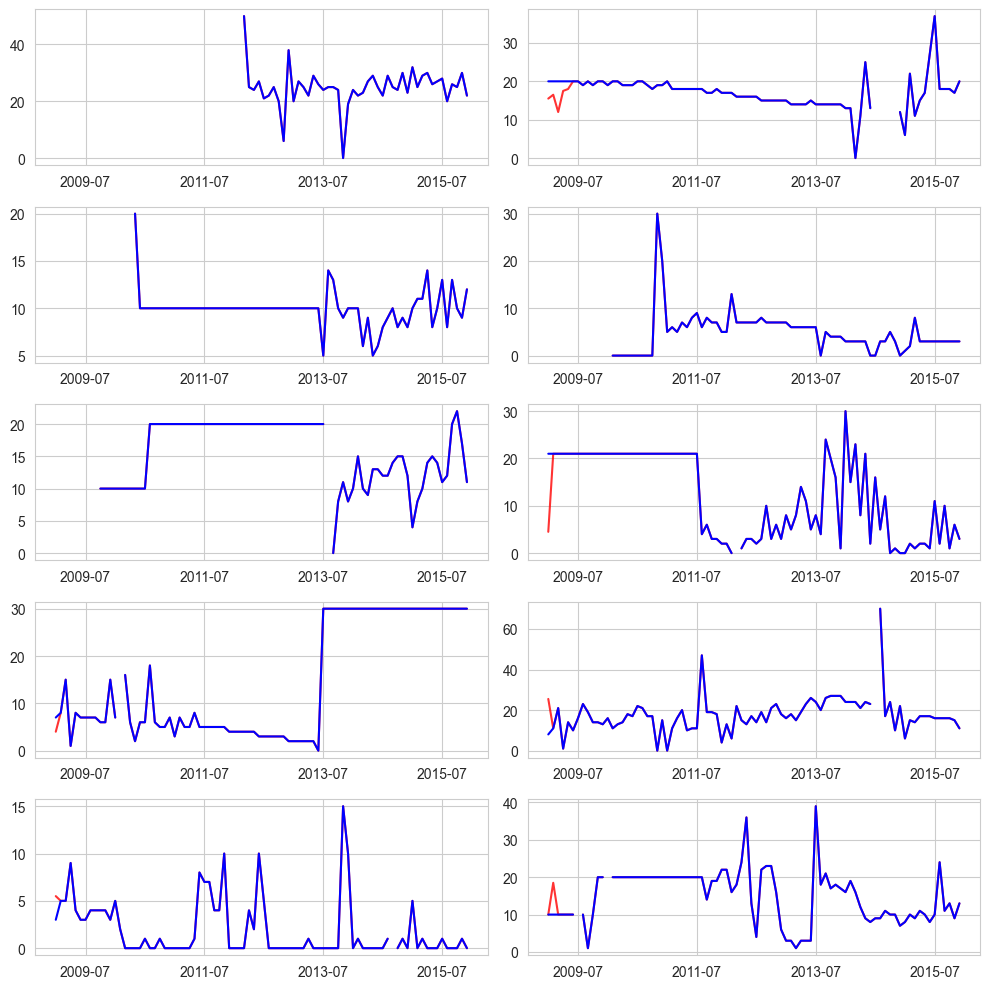

In [264]:
## Plot a few imputed graphs by highlighting imputed values in red
np.random.seed(14)
num_example = 10
pltnum = np.random.randint(0,len(interupted), num_example)
before = interupted.iloc[pltnum]

idx = before.index[list(range(num_example))]
after = result.loc[idx]
before = before.iloc[:,5:89]
after = after.iloc[:,5:89]

%matplotlib inline
fig, ax = plt.subplots(5,2, figsize=(10,10))

for i in range(num_example):
    #plt.plot(before, color='r')
    after.iloc[i].plot(kind='line',color='r', alpha=0.8, ax=ax[i//2,i%2])
    #plt.subplot(5,2,i+1)
    before.iloc[i].plot(kind='line',color='b', linewidth=1.5, alpha=1, ax=ax[i//2,i%2])
    #plt.subplot(5,2,i+1)
    
plt.setp(ax, xticks=list(range(6,len(NumNullwithTime.index),24)), xticklabels=list(NumNullwithTime.index[6::24]))
plt.tight_layout()
#plt.show()

* **Imputación con SimpleImputer**

In [221]:

data = aguah.iloc[0:, 5:]

imputer = SimpleImputer(strategy='median')

imputed_array = imputer.fit_transform(data)


df_imputed = pd.DataFrame(imputed_array, columns=data.columns)


df_imputed.to_csv('datos_imputados.csv', index=False)

* **Serie de tiempo con los datos imputados**

Con los datos imputados, graficamos el consumo con respecto al tiempo.

In [274]:
df_datos_imputados = pd.read_csv('datos_imputados_KNN.csv')
df_long = df_datos_imputados.iloc[0:, 6:]
df_long

2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  \
0          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
1          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
2          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
3          20.0     20.0     20.0     20.0     20.0     20.0     20.0   
4          30.0     10.0     30.0     20.0     30.0     30.0     30.0   
...         ...      ...      ...      ...      ...      ...      ...   
178592      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
178593      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
178594     15.0     15.0     15.0     15.0     15.0     15.0     15.0   
178595      NaN      NaN      NaN      NaN      0.0      0.0      0.0   
178596     30.0     30.0     30.0     30.0     30.0     30.0     30.0   

        2009-08  2009-09  2009-10  ...    2015-03    2015-04    2015-05  \
0          20.0     20.0     20.0  ...   2.000000   1.000000   2.000000   
1          20.0     20.0     20.0  ...  27.000000  27.000000  27.000000   
2          17.0     14.0     10.0  ...  19.000000  19.000000  18.000000   
3          20.0     20.0     20.0  ...  17.000000  17.000000  17.000000   
4          30.0     30.0     30.0  ...  14.000000  15.000000  26.000000   
...         ...      ...      ...  ...        ...        ...        ...   
178592      NaN      NaN      NaN  ...  17.000000  30.000000  28.000000   
178593      NaN      NaN      NaN  ...   0.000000  48.000000   9.000000   
178594     15.0     15.0     15.0  ...  40.789474  41.710526  42.631579   
178595      0.0      0.0      0.0  ...   7.000000  12.000000   9.000000   
178596     30.0     30.0     30.0  ...  34.526316  35.473684  36.421053   

          2015-06    2015-07    2015-08    2015-09    2015-10    2015-11  \
0        1.000000   7.000000   7.000000  42.000000  27.000000  22.000000   
1       28.000000  28.000000  31.000000  27.000000  27.000000  27.000000   
2       18.000000  19.000000  19.000000  19.000000  18.000000  18.000000   
3       17.000000  17.000000  17.000000  17.000000  17.000000  17.000000   
4       27.000000  29.000000  22.000000  27.000000  26.000000  33.000000   
...           ...        ...        ...        ...        ...        ...   
178592  26.000000  16.000000  34.000000  23.000000  21.000000  31.000000   
178593  43.000000  42.000000  43.000000  41.000000  36.000000  32.000000   
178594  43.552632  44.473684  45.394737  46.315789  47.236842  48.157895   
178595   9.000000  12.000000  10.000000   9.000000   8.000000  12.000000   
178596  37.368421  38.315789  39.263158  40.210526  41.157895  42.105263   

          2015-12  
0       21.000000  
1       24.000000  
2       24.000000  
3       24.000000  
4       32.000000  
...           ...  
178592  20.000000  
178593  16.000000  
178594  49.078947  
178595   8.000000  
178596  43.052632  

[178597 rows x 84 columns]

In [278]:
df_long = df_datos_imputados.melt(var_name='Fecha', value_name='Consumo')
df_long['Fecha'] = pd.to_datetime(df_long['Fecha'], format='%Y-%m', errors='coerce')
df_long = df_long.groupby('Fecha')['Consumo'].sum().reset_index()
df_consumo_total = df_long.copy()
df_consumo_total['Fecha'] = pd.to_datetime(df_consumo_total['Fecha'])
df_consumo_total

Fecha          Consumo
0  2009-01-01        9372506.5
1  2009-02-01   7029116.263158
2  2009-03-01   5568504.276316
3  2009-04-01   6150863.857656
4  2009-05-01   6865531.522545
..        ...              ...
79 2015-08-01  17799041.328627
80 2015-09-01  19535532.662902
81 2015-10-01  10923627.997176
82 2015-11-01  15185690.331451
83 2015-12-01  14030023.665725

[84 rows x 2 columns]

<Axes: title={'center': 'Serie de Consumo Total por Fecha'}, xlabel='Fecha'>

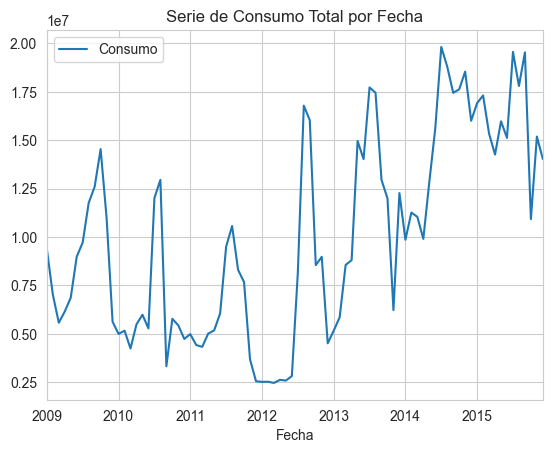

In [280]:
df_temp = df_consumo_total.copy().set_index('Fecha')
df_temp.plot(title="Serie de Consumo Total por Fecha")


El consumo de agua aumenta con el paso del tiempo del 2009 al 2015 el consumo muestra una tendencia ascendente, aunque también se presentan caidas en periodos intermedios.
Un aspecto importante a considerar es la variabilidad, algunos periodos muestra caídas muy bruscas y repidaente se recuperan, siendo una muy clara muestra que el consumo no es constante si no que fluctua


mean           std
Año                             
2009  1.087858e+07  3.440619e+06
2010  7.240108e+06  3.423263e+06
2011  6.734933e+06  2.721587e+06
2012  7.089517e+06  5.690111e+06
2013  1.208259e+07  4.666698e+06
2014  1.551782e+07  3.761495e+06
2015  1.632464e+07  2.499876e+06

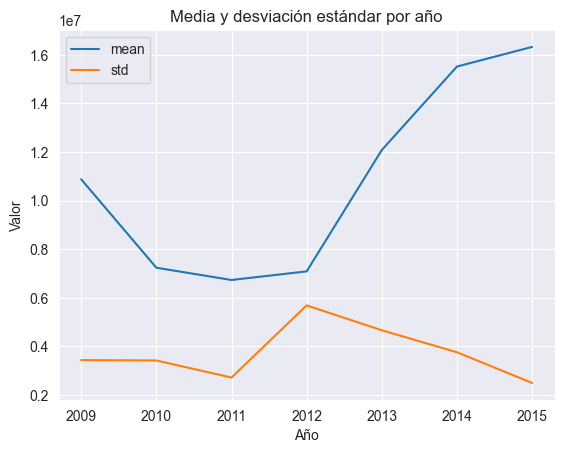

In [146]:
calcular_estadisticas(df_consumo_total)

Saco el ACF del consumo total para identificar una estacionalidad, se supone que como despues del descenso de los coeficientes ACF del consumo actual sigue un pico en 12, entonces respalda la hipótesis de que la estacionalidad está en 12 meses

C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\783694364.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


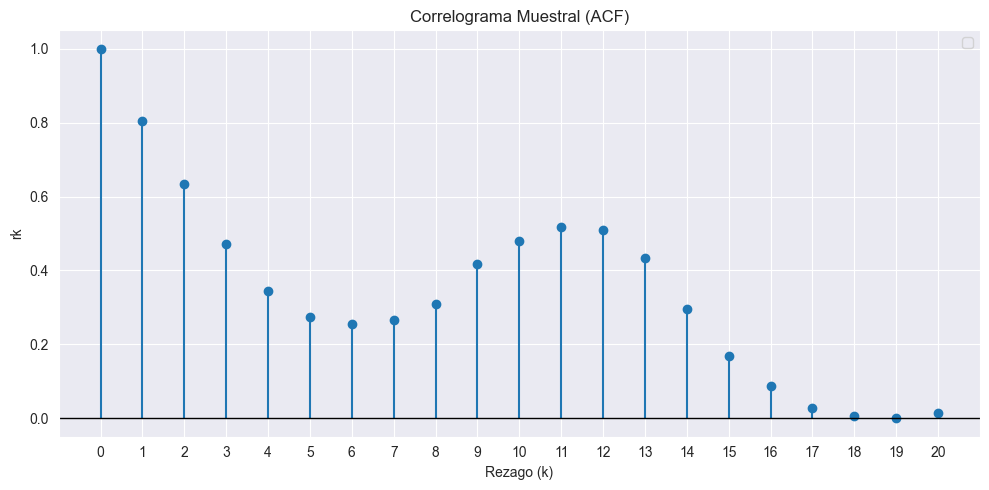

array([ 1.00000000e+00,  8.03445244e-01,  6.33467383e-01,  4.70913588e-01,
        3.42992277e-01,  2.72562922e-01,  2.54497368e-01,  2.65025706e-01,
        3.10131338e-01,  4.17023973e-01,  4.78879533e-01,  5.16572208e-01,
        5.08252081e-01,  4.32215667e-01,  2.95175735e-01,  1.66908110e-01,
        8.74081623e-02,  2.83695206e-02,  4.78944696e-03, -6.78479681e-04,
        1.32255066e-02])

In [165]:
coeficientes_rk(df_consumo_total)

* **Normalización de los datos**

Ya con los datos imputados, se procedió a normalizarlos.

In [ ]:
df_temp = pd.read_csv("datos_imputados.csv")
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns)
df_normalizado

2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07  \
0       0.000810  0.000829  0.000829  0.000762  0.000471  0.000449  0.000416   
1       0.002622  0.001243  0.001243  0.001143  0.000707  0.000674  0.000625   
2       0.002622  0.001984  0.001568  0.001589  0.001090  0.001351  0.001349   
3       0.002622  0.001984  0.001568  0.001589  0.001090  0.001351  0.001349   
4       0.000810  0.000829  0.000829  0.000762  0.000471  0.000449  0.000416   
...          ...       ...       ...       ...       ...       ...       ...   
178592  0.104244  0.069830  0.047286  0.050160  0.035856  0.053657  0.054550   
178593  0.104244  0.069830  0.047286  0.050160  0.035856  0.053657  0.054550   
178594  0.104244  0.069830  0.047286  0.050160  0.035856  0.053657  0.054550   
178595  0.104244  0.069830  0.047286  0.050160  0.035856  0.053657  0.054550   
178596  0.104244  0.069830  0.047286  0.050160  0.035856  0.053657  0.054550   

         2009-08   2009-09   2009-10  ...   2015-03   2015-04   2015-05  \
0       0.000401  0.000408  0.000401  ...  0.000036  0.000020  0.000041   
1       0.000601  0.000613  0.000601  ...  0.000199  0.000255  0.000324   
2       0.001568  0.001706  0.001927  ...  0.000109  0.000177  0.000142   
3       0.001568  0.001706  0.001927  ...  0.000308  0.000393  0.000324   
4       0.000401  0.000408  0.000401  ...  0.000489  0.000530  0.000547   
...          ...       ...       ...  ...       ...       ...       ...   
178592  0.068166  0.077280  0.091175  ...  0.089264  0.085291  0.103761   
178593  0.068166  0.077280  0.091175  ...  0.089264  0.085291  0.103761   
178594  0.068166  0.077280  0.091175  ...  0.089264  0.085291  0.103761   
178595  0.068166  0.077280  0.091175  ...  0.089264  0.085291  0.103761   
178596  0.068166  0.077280  0.091175  ...  0.089264  0.085291  0.103761   

         2015-06   2015-07   2015-08   2015-09   2015-10   2015-11   2015-12  
0       0.000032  0.000282  0.000352  0.004292  0.005207  0.000631  0.000607  
1       0.000447  0.000605  0.000805  0.001329  0.003279  0.000488  0.000318  
2       0.000255  0.000322  0.000503  0.001226  0.001736  0.000172  0.000087  
3       0.000511  0.000726  0.000905  0.001737  0.003279  0.000516  0.000260  
4       0.000894  0.001129  0.001559  0.002759  0.005207  0.000774  0.000694  
...          ...       ...       ...       ...       ...       ...       ...  
178592  0.151781  0.259744  0.290822  0.661829  0.602314  0.136420  0.128190  
178593  0.151781  0.259744  0.290822  0.661829  0.602314  0.136420  0.128190  
178594  0.151781  0.259744  0.290822  0.661829  0.602314  0.136420  0.128190  
178595  0.151781  0.259744  0.290822  0.661829  0.602314  0.136420  0.128190  
178596  0.151781  0.259744  0.290822  0.661829  0.602314  0.136420  0.128190  

[178597 rows x 84 columns]

In [219]:
df_temp = df_datos_imputados.melt(var_name='Fecha', value_name='Consumo')
df_temp = df_temp.groupby('Fecha')['Consumo'].sum().reset_index()
df_consumo_total_normalizado = df_temp.copy()
df_consumo_total_normalizado['Fecha'] = pd.to_datetime(df_consumo_total['Fecha'])
df_consumo_total_normalizado

Fecha       Consumo
0  2009-01-01  1.156379e+07
1  2009-02-01  8.550169e+06
2  2009-03-01  6.758467e+06
3  2009-04-01  7.445560e+06
4  2009-05-01  8.257061e+06
..        ...           ...
79 2015-08-01  1.810500e+07
80 2015-09-01  1.986351e+07
81 2015-10-01  1.109785e+07
82 2015-11-01  1.541973e+07
83 2015-12-01  1.424168e+07

[84 rows x 2 columns]

<Axes: title={'center': 'Serie de Consumo Total por Fecha'}, xlabel='Fecha'>

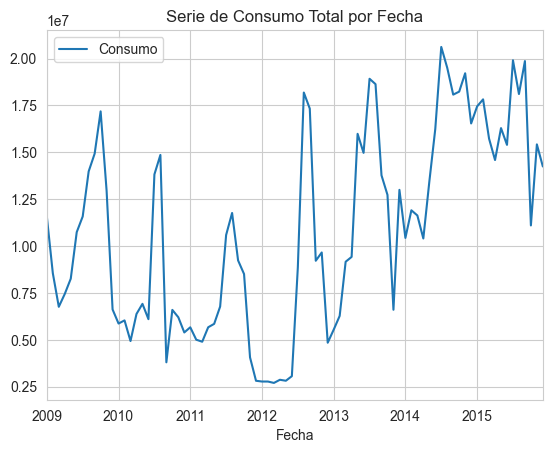

In [220]:
df_temp = df_consumo_total_normalizado.copy().set_index('Fecha')
df_temp.plot(title="Serie de Consumo Total por Fecha")

---

## Modelamiento con método Box-Jenkins

In [147]:
df_consumo_total.to_csv("consumo_total.csv", index = True)

mean           std
Año                             
2010 -3.638467e+06  4.226952e+06
2011 -5.051747e+05  2.422779e+06
2012  3.545837e+05  4.190626e+06
2013  4.993074e+06  5.417568e+06
2014  3.435232e+06  3.734900e+06
2015  8.068184e+05  4.219539e+06

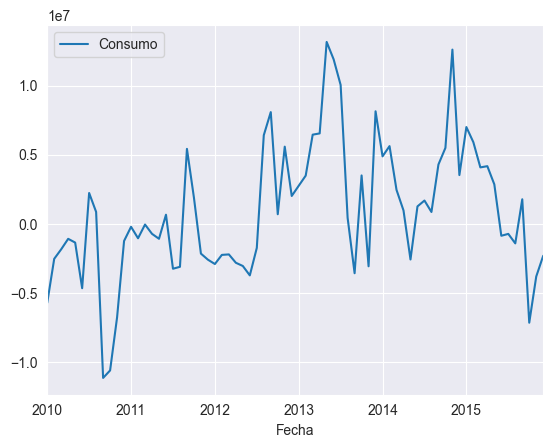

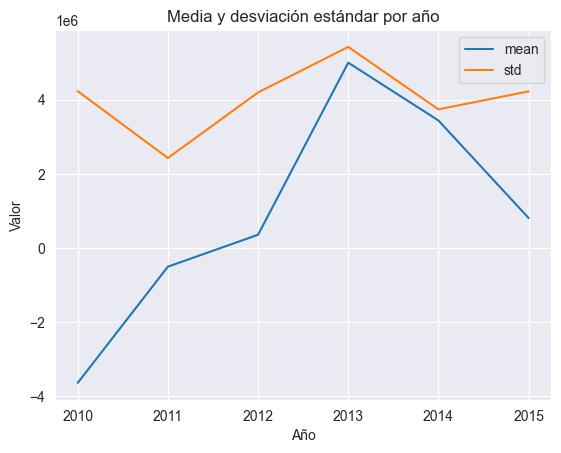

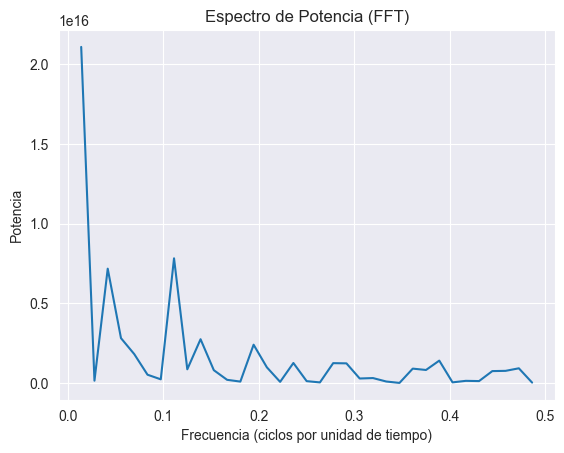

In [148]:
df_dif_1 = diferenciar(df_consumo_total)
graficar(df_dif_1)
calcular_estadisticas(df_dif_1)
periodograma(df_dif_1)

mean           std
Año                             
2010 -3.638467e+06  4.226952e+06
2011 -5.051747e+05  2.422779e+06
2012  3.545837e+05  4.190626e+06
2013  4.993074e+06  5.417568e+06
2014  3.435232e+06  3.734900e+06
2015  8.068184e+05  4.219539e+06

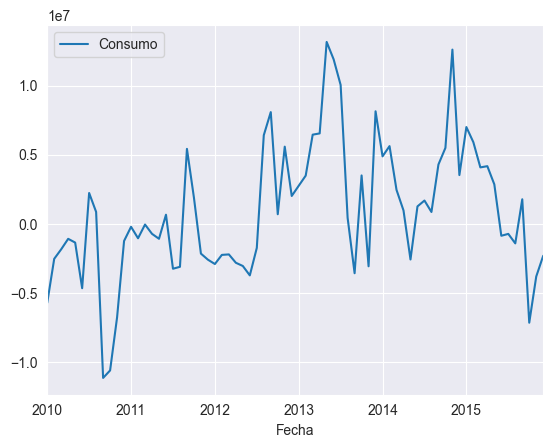

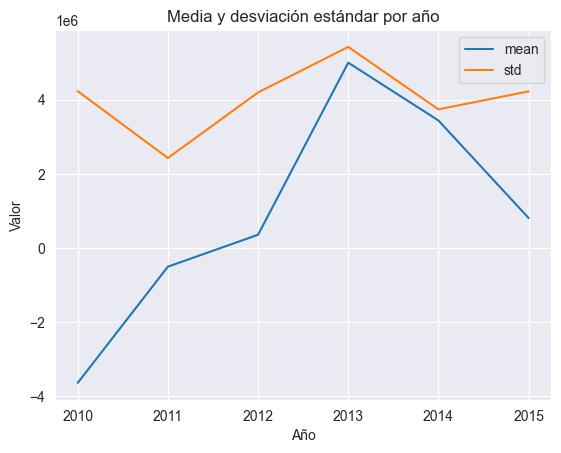

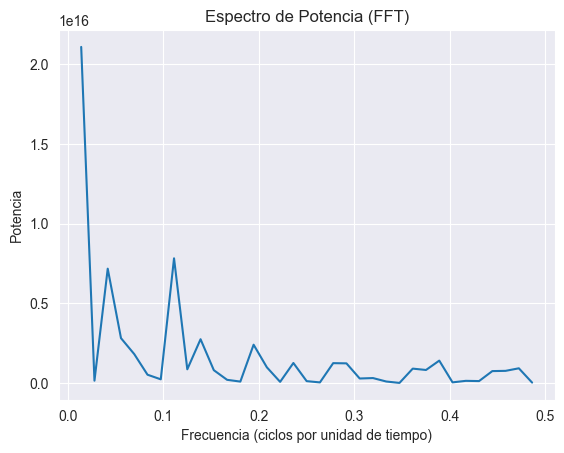

In [149]:
df_dif_2 = diferenciar(df_dif_1)
df_dif_2 = diferenciar(df_consumo_total)
graficar(df_dif_2)
calcular_estadisticas(df_dif_2)
periodograma(df_dif_2)

C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\783694364.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


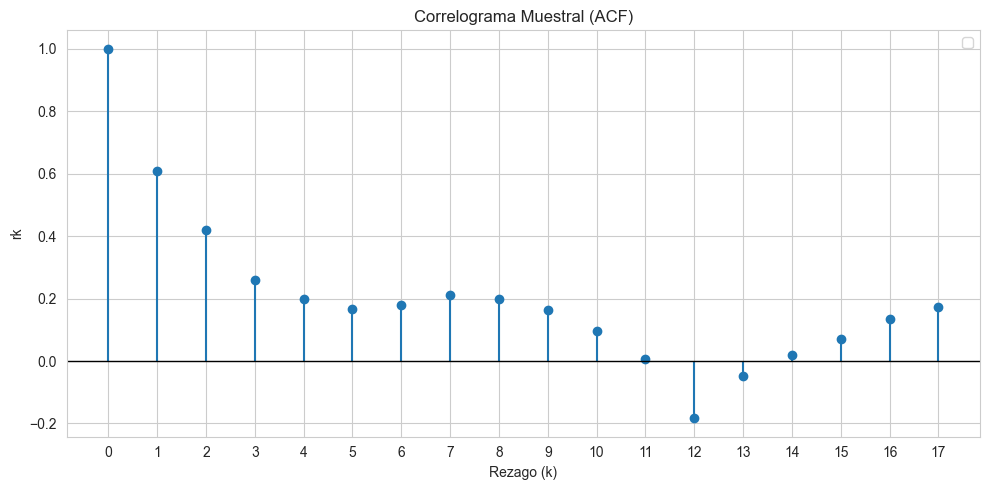

array([ 1.        ,  0.60824934,  0.41824458,  0.2611168 ,  0.19906205,
        0.16781356,  0.18117224,  0.21018566,  0.19724238,  0.16265622,
        0.09766674,  0.00538395, -0.18320142, -0.0467366 ,  0.01922269,
        0.0715328 ,  0.13524808,  0.17353303])

In [202]:
coeficientes_rk(df_dif_1)

---

### Experimento usando librerias de python para ACF y PACF

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

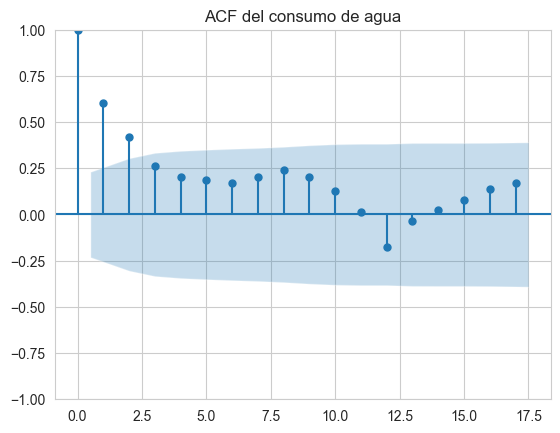

In [205]:

# Asumiendo que tienes un DataFrame llamado df con columna 'Consumo'
plot_acf(df_dif_1['Consumo'], lags=17)
plt.title("ACF del consumo de agua")
plt.show()


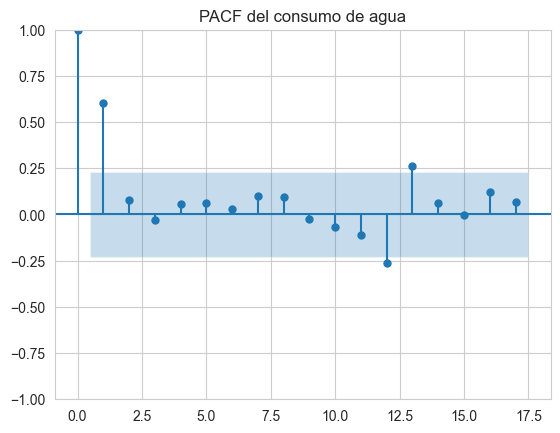

In [206]:
plot_pacf(df_dif_1['Consumo'], lags=17)
plt.title("PACF del consumo de agua")
plt.show()

---

## Función de autocorrelación estimada

La cantidad optima de rezagos a calcular se puede aproximar con:
$$
número de rezagos 
\approx
\frac{número de datos}{4}
$$

$$
número de rezagos 
\approx
\frac{72}{4}
\approx
18
$$

$$
r_k
=
\frac{\sum^T_{t =k+1} (x_t - \hat{x}) (x_{t-k} - \hat{x})}{\sum^T_{t = 1} (x_t - \hat{x})^2}
$$

C:\Users\Sachistein\AppData\Local\Temp\ipykernel_3080\783694364.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


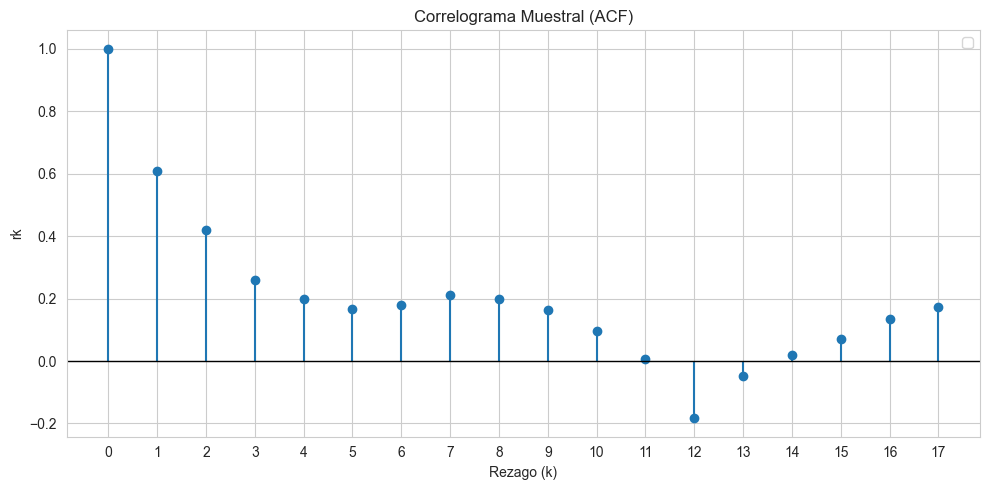

[ 1.          0.60824934  0.41824458  0.2611168   0.19906205  0.16781356
  0.18117224  0.21018566  0.19724238  0.16265622  0.09766674  0.00538395
 -0.18320142 -0.0467366   0.01922269  0.0715328   0.13524808  0.17353303]


In [207]:
rk = coeficientes_rk(df_dif_1)
print(rk)


$$
r_k 
=
\left(
\begin{array}{c}
1.0 \\
0.6082493434988753 \\
0.41824457569429163 \\
0.26111680314354235 \\
0.19906205261224516 \\
0.16781356383140636 \\
0.18117224424582112 \\
0.21018566131384922 \\
0.19724238323856266 \\
0.1626562152243389 \\
0.09766674207526796 \\
0.005383947155139377 \\
-0.18320142462082542 \\
-0.04673659588960856 \\
0.01922269055931879 \\
0.07153280023528318 \\
0.1352480808476952 \\
0.17353303048468904 \\
\end{array}
\right)
$$

---

### Función de autocorrelación parcial estimada

Primer término de la autocorrelación parcial denotado por $\phi_1$ puede estimarse transformando la serie $x_t$ en desviaciones respecto a su medio muestral 
$$
y_t = x_t - \hat{x}
$$
y a continuación estimando una regresión de $y_t$ sobre y $y_{t-1}$, la pendiente estimada de esta regresión es $\phi_1$

In [209]:
y = calcular_yt(df_dif_1)
phi = (y[3] - y[2] - 0.6*y[1])/y[0]
print(phi)

-0.42557772442243597


El primer valor de la función de autocorrelación parcial $\phi_1$ es igual al primer valor de autocorrelación $r_1$, propiedad de las funciones de autocorrelación de todo proceso estocástico
estacionario.

$$
y_t
=
\phi_1 y_{t-1} +
\phi_2 y_{t-2} +
\phi_3 y_{t-3} + \dots
\phi_k y_{t-k} + u_t
$$

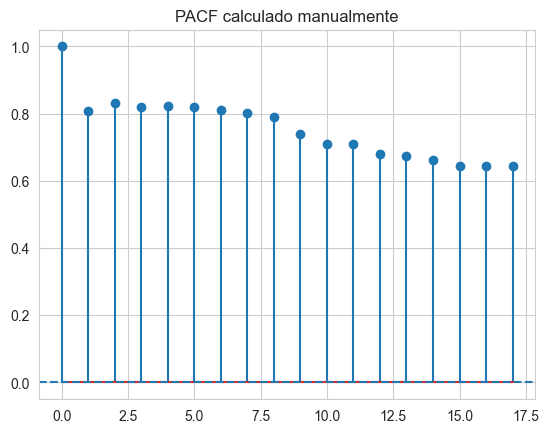

In [195]:
pacf_vals = calcular_pacf(df_consumo_total['Consumo'], max_lag=17)

plt.stem(range(len(pacf_vals)), pacf_vals)
plt.axhline(y=0, linestyle='--')
plt.title("PACF calculado manualmente")
plt.show()

---

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose

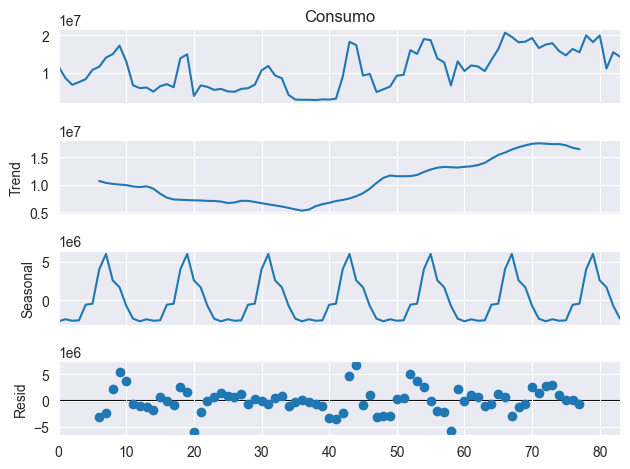

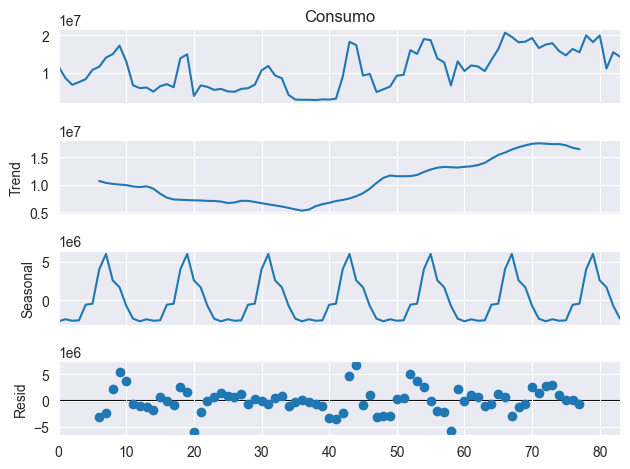

In [156]:
result = seasonal_decompose(df_consumo_total['Consumo'], model='additive', period=12)
result.plot()

In [157]:
from statsmodels.tsa.arima.model import ARIMA

In [158]:
model = ARIMA(df_consumo_total['Consumo'], order=(12,1,2))
result = model.fit()

c:\Users\Sachistein\Proyecto_MN\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [160]:
pronostico = result.forecast(steps=12)
print(pronostico)

84    1.562075e+07
85    1.643302e+07
86    1.512267e+07
87    1.531338e+07
88    1.505102e+07
89    1.750096e+07
90    1.677925e+07
91    1.772185e+07
92    1.587415e+07
93    1.453128e+07
94    1.446093e+07
95    1.526772e+07
Name: predicted_mean, dtype: float64


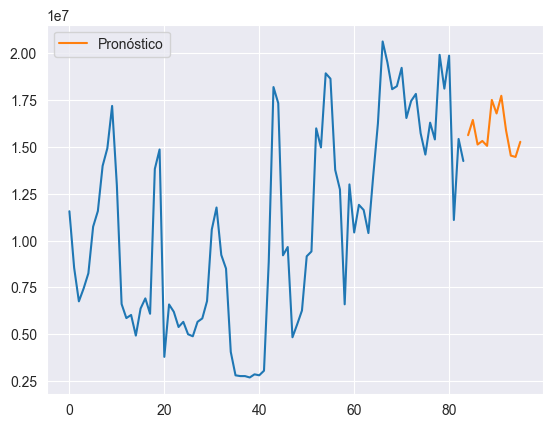

In [161]:
df_consumo_total['Consumo'].plot(label='Histórico')
pronostico.plot(label='Pronóstico', legend=True)
plt.show()

$$
 Y_{t}-\delta_{0}-\delta_{1}t-\ldots-\delta_{k}t^{k}-X_{t}\beta
            =\epsilon_{t} \\
        \left(1-L\right)^{d}\left(1-L^{s}\right)^{D}\Phi\left(L\right)
        \Phi_{s}\left(L\right)\epsilon_{t}
            
        =\Theta\left(L\right)\Theta_{s}\left(L\right)\eta_{t}
$$